# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

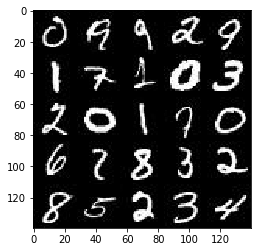

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

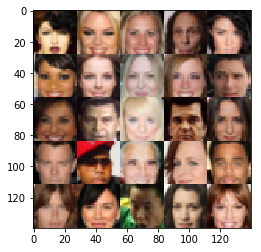

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    # TODO: Implement Function
    ALPHA = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(ALPHA * x1, x1)
        
        # 14x14x64        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(ALPHA * bn2, bn2)
        
        # 7x7x128       
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(ALPHA * bn3, bn3)
        
        # 4x4x256
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        # 7x7x256
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xchannel now

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth=0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    # may cause the error : list index out of range
    
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1) 
    
    saver = tf.train.Saver()
    
    #recording training results
    steps = 0
    print_every=20
    show_every=50
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # real image in range [-1, 1] tanh
                batch_images *= 2
                
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images, 
                                               learn_rate: learning_rate}) 
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

In [13]:
mnist_dataset.shape

(60000, 28, 28, 1)

Epoch 1/2... Discriminator Loss: 0.4977... Generator Loss: 14.0771
Epoch 1/2... Discriminator Loss: 0.4093... Generator Loss: 2.8282


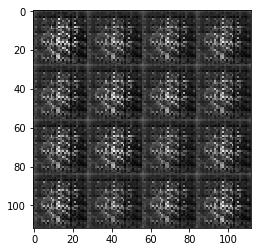

Epoch 1/2... Discriminator Loss: 0.5580... Generator Loss: 9.8156
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 2.8603
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.1789


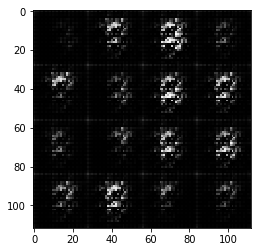

Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 3.1193
Epoch 1/2... Discriminator Loss: 0.4636... Generator Loss: 3.3436


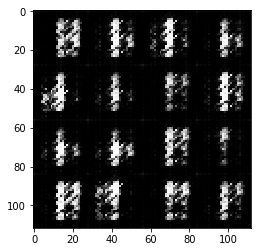

Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 2.6887
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 4.3407
Epoch 1/2... Discriminator Loss: 0.5441... Generator Loss: 5.1330


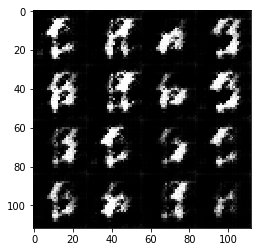

Epoch 1/2... Discriminator Loss: 0.4771... Generator Loss: 3.2744
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 2.2756


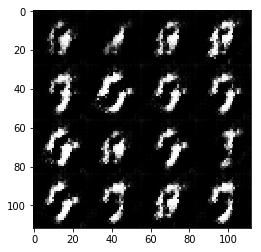

Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 1.8007
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 1.5940
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.9208


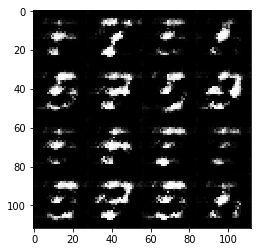

Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 3.6927
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 2.9070


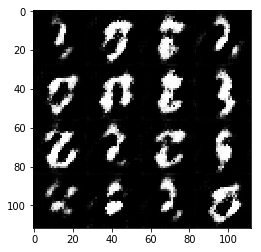

Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 2.4646
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 2.7312
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.6444


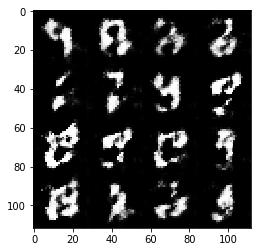

Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 4.2354
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.3575


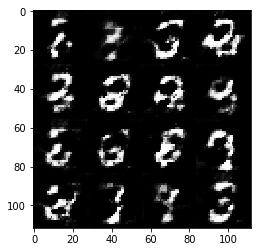

Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 2.9981
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.9339
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 2.1124


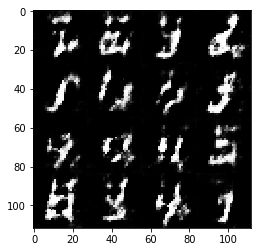

Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 0.6628... Generator Loss: 2.6302


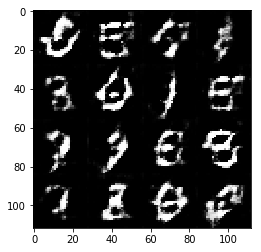

Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 4.1678
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 2.2339


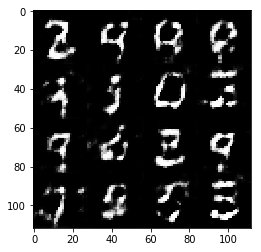

Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.8303
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 1.4889


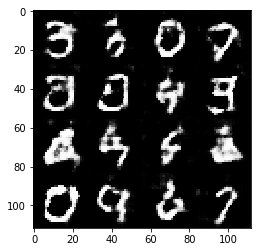

Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 2.1321
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.4492


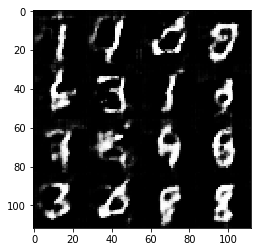

Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.6157


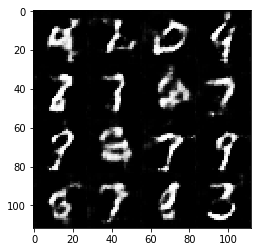

Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 1.7989


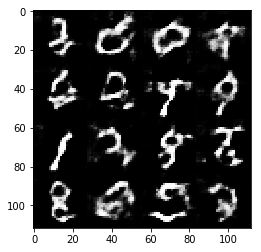

Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 2.4010
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 2.4636


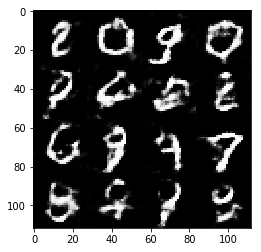

Epoch 1/2... Discriminator Loss: 0.8340... Generator Loss: 1.3724
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 1.2733
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 1.1166


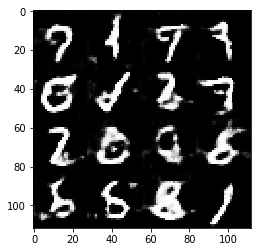

Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 2.5662
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.3607


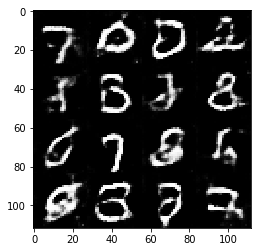

Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 2.5918
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.2673
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 0.8313


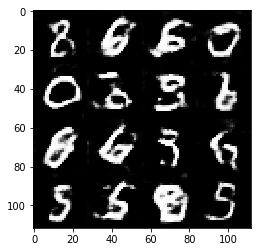

Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 1.6787
Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 1.9342


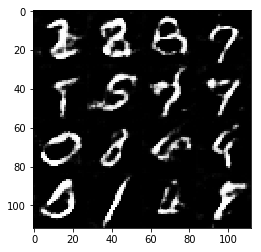

Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.7746
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.5136
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.0272


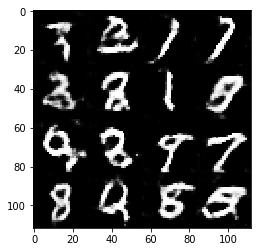

Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 1.8700
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.2858


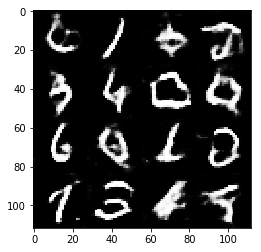

Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.9705


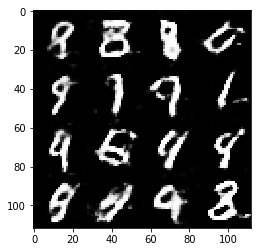

Epoch 2/2... Discriminator Loss: 0.8282... Generator Loss: 1.4144
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 0.7831


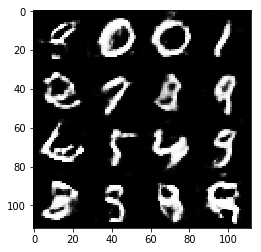

Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.8036
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.6726


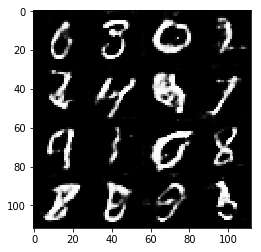

Epoch 2/2... Discriminator Loss: 1.5825... Generator Loss: 0.4616
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.9819


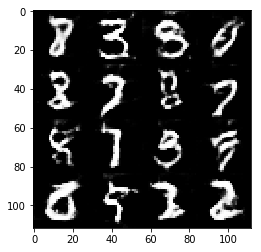

Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.9102
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.6414
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 2.3374


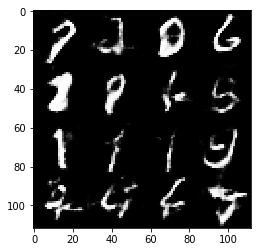

Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.4287


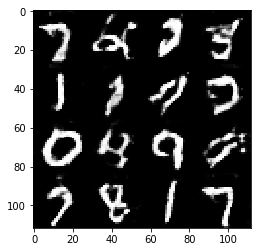

Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 1.0326


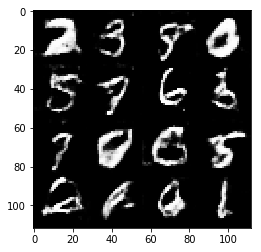

Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.6680


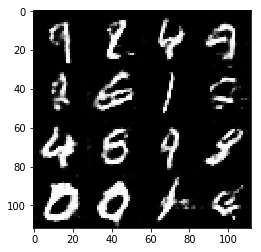

Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.6883
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.6240


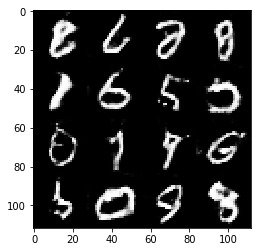

Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 2.7821
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 3.6457


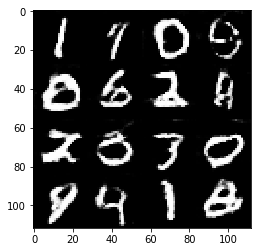

Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 1.4411
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.7401
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.7205


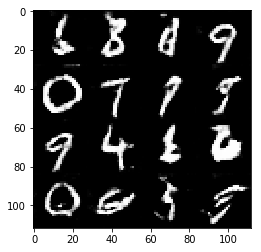

Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 1.8525


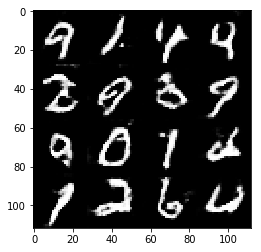

Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 1.4840... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.0484


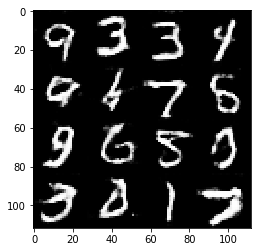

Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.7366
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.8007


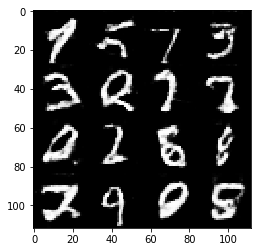

Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 2.3217


In [14]:
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 6.7598
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 15.1102


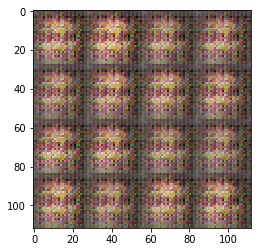

Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 5.6030
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.9514
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.3004


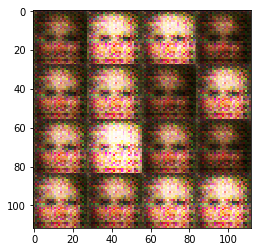

Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 2.0495
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.7231


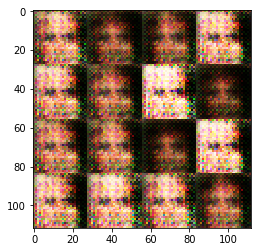

Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.8095


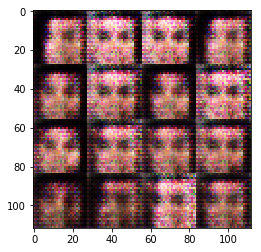

Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7010


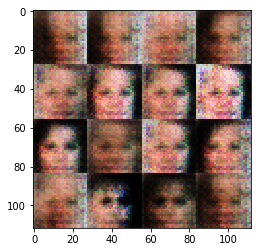

Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.5151
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.3577


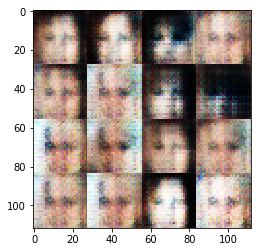

Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 0.5145


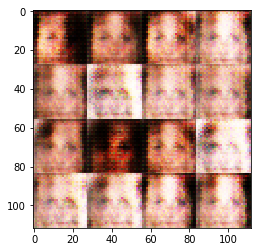

Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.1281


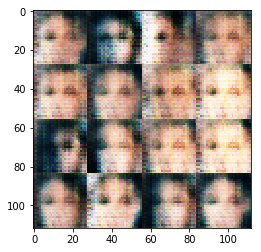

Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.6449


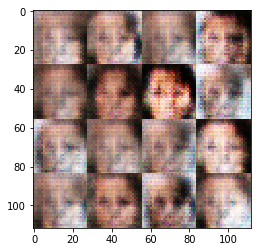

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 1.8278
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.6994


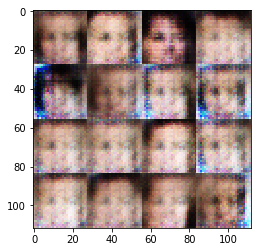

Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.2568
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.8052


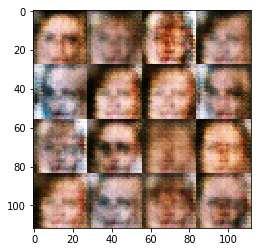

Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6543


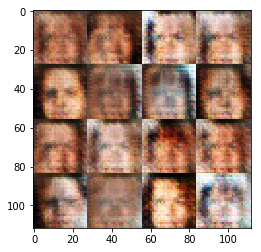

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.3408


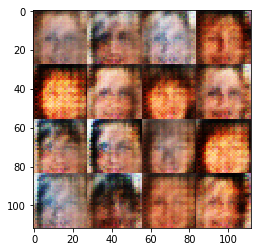

Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.9039
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.2177


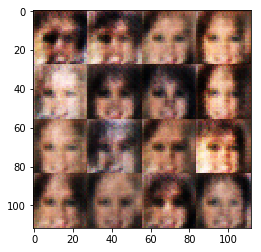

Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.4128


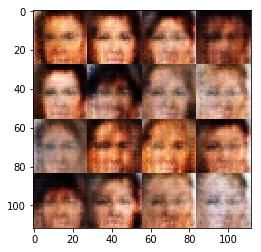

Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.1491


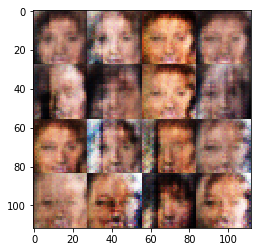

Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.0557


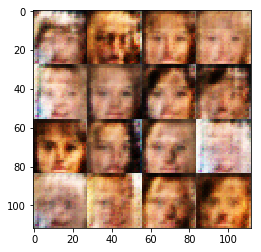

Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 2.6578
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0909


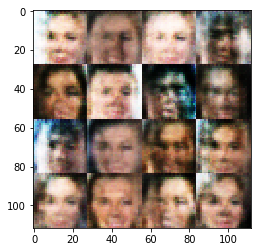

Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.2175


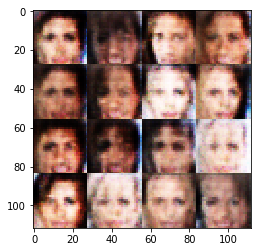

Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.3613


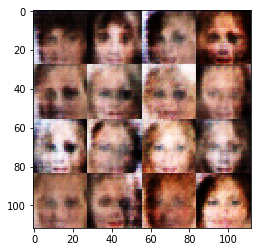

Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.3553
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.5729


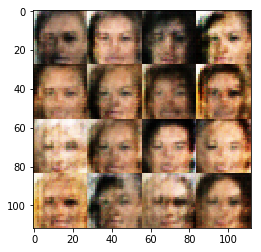

Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.9872


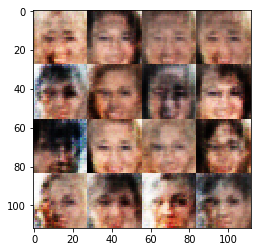

Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.2558


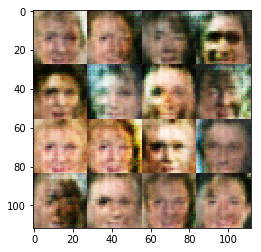

Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.6348


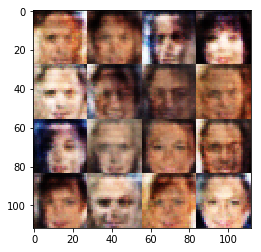

Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.9213


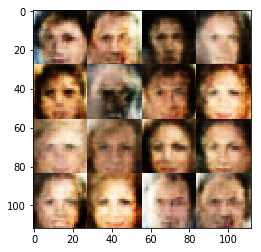

Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.9281
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.1807


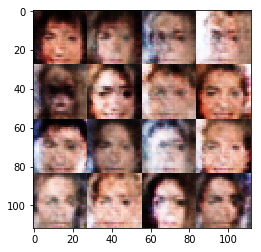

Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9369


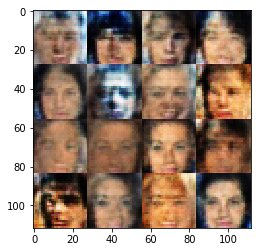

Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 2.4479
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7835


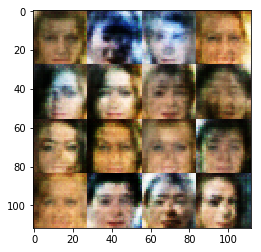

Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 2.6183


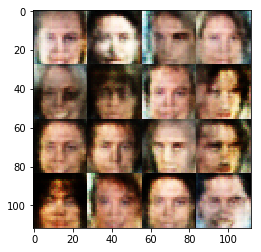

Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8234


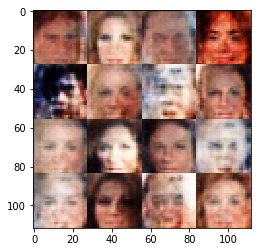

Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.1858


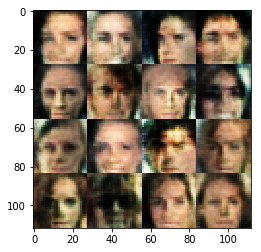

Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.6035


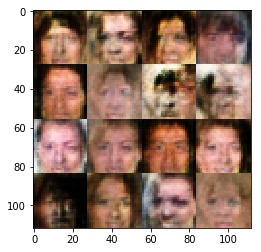

Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.0212


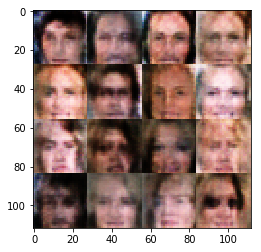

Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0520


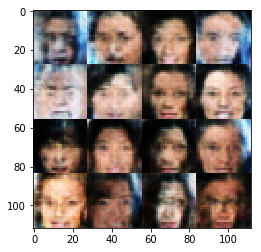

Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.8622


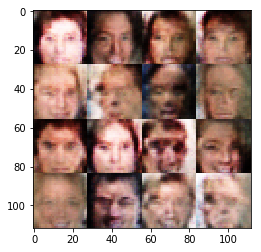

Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5900


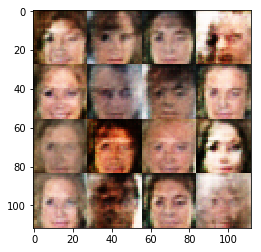

Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.8832


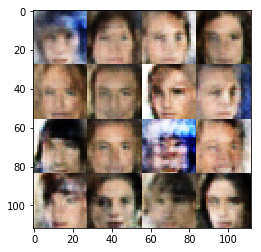

Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.7931


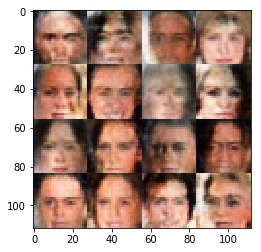

Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.7573


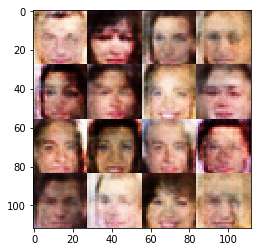

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.1190


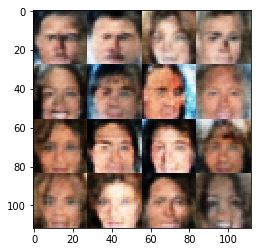

Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.5153


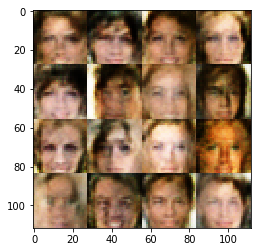

Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9144


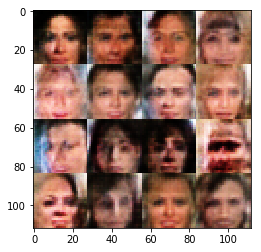

Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.2828


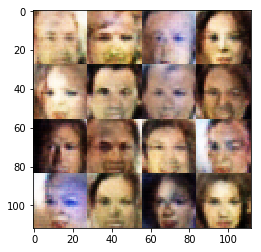

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.5175


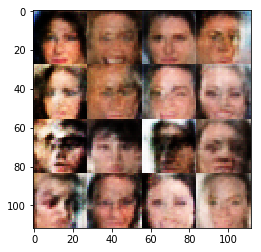

Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 2.4309


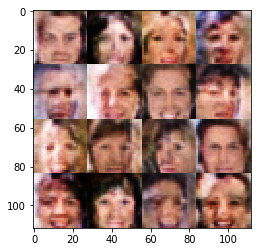

Epoch 1/1... Discriminator Loss: 1.9781... Generator Loss: 0.2702
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.9014


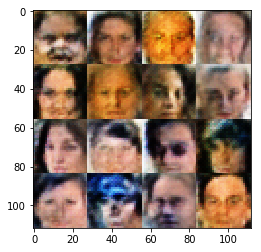

Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.1176


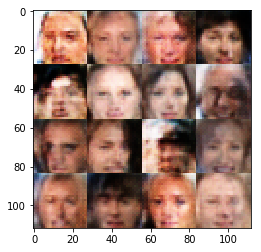

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.4571


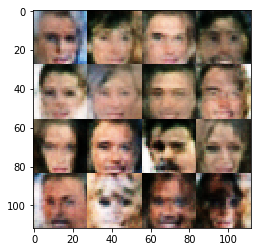

Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.3880
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8227


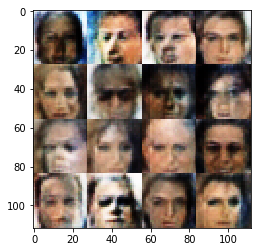

Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.1247


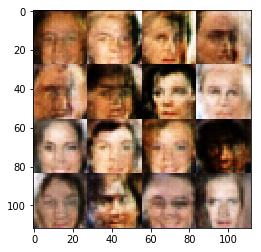

Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.2843


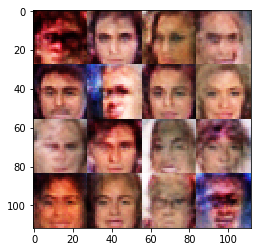

Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.5797


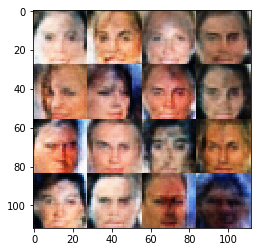

Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.9709


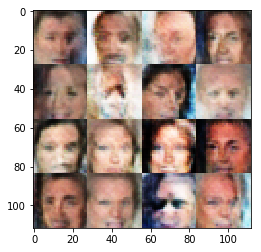

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7974


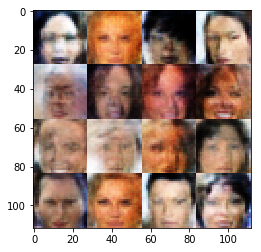

Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.5981
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.4119


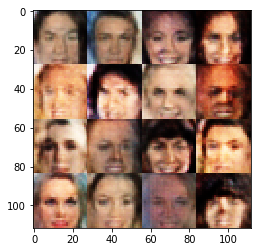

Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7236


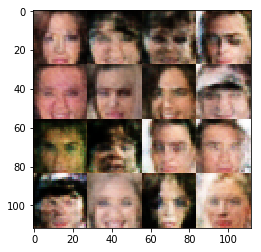

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.7582


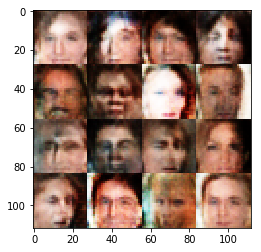

Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.9504
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8764


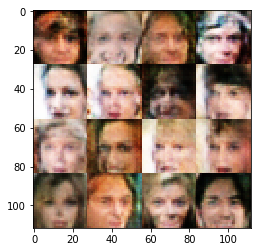

Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.6701


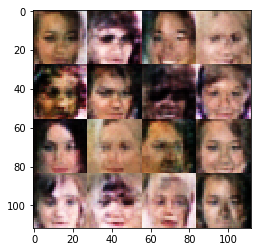

Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.7671


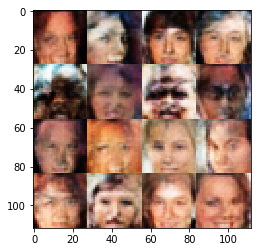

Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.1150


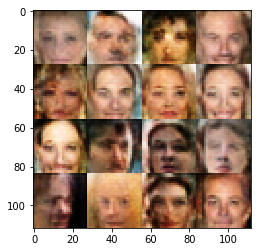

Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.6160


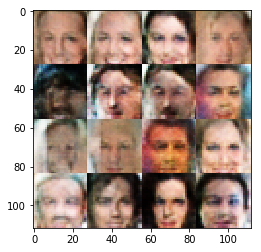

Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6314


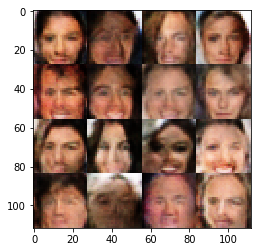

Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.3261


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.